In [1]:
import sys
import numpy as np
import os
import glob
import pandas as pd
sys.path.append('../OnStove')

from plotnine import geom_vline, annotate, theme
from plotnine.stats.stat_boxplot import weighted_percentile
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from onstove import MCA, OnStove, RasterLayer, VectorLayer

# 1. Creating an MCA model

In [4]:
nepal = MCA(project_crs=3857, cell_size=(1000, 1000))
output_directory = '../5. Results/MCA'
nepal.output_directory = output_directory

In [5]:
adm_path = r"../5. Results/Administrative\Country_boundaries/Country_boundaries.geojson"
nepal.add_mask_layer(category='Administrative', name='Country_boundaries', path=adm_path)

## 1.1. Adding data layers
Similar to the data processing steps, we can add data layers using the `add_layer` method. A layer `category`, `name` and `path` also need to be provided. In addition, other arguments can be passed:
* `category`: this is used to group all datasets into a category in the final output, e.g. `demand` or `supply`. 
* `name`: the name of the layer.
* `path`: relative path where the layer file is stored, including the name and extension.
* `layer_type`: this argument is required with two possible options `raster` or `vector`, we should pass either one according to the dataset you are adding. 
* `scoring_method`: the method to be used to calculate the distance raster for this layer. 
    * For `raster` layers, only `log` is available. This will create a logarithmic representation of the original raster. If this is not desired, we should pass `None` to the `distance` parameter (this is the defaul value), which will take the original raster as the distance raster.
    * For `vector` layers, two options are available `proximity` and `time_travel`. `proximity`, calculates a distance raster using the vectors (e.g. points, lines, polygons) as origin; the output raster will have the same dimentions and cell size as the `base_layer` (i.e. see below). `time_travel`, will need a friction raster (which can be added later) that will be used to calculate the least cost path to every cell taking the vectors as starting points.
* `normalization`: currently only `MinMax` normalization is available. This is used to normalize the distance rasters in a 0 to 1 range, which will be used later to calculate the CCE Demand, Supply and Clean Cooking potential indexes.
* `inverse`: we can specify if the scale of the ormalization need to be reversed, depending on the nature of the dataset.

#### We will then read in the layers that we created in the `Data Processing` step:

In [6]:
nepal.add_layer(category='Demographics', name='Population', path='../5. Results/Demographics\Population\Population.tif',
                layer_type='raster', normalization='MinMax', inverse=False, 
                distance_method='log', base_layer=True)

nepal.add_layer(category='Electricity', name='Existing MV lines', 
                path=r"..\5. Results\Electricity/MV_lines/MV_lines.geojson",
                layer_type='vector', #query='Status == "In Service"',
                normalization='MinMax', inverse=True, 
                distance_method='proximity')

nepal.add_layer(category='Electricity', name='Existing Mini Grids', 
                path=r"..\5. Results\Electricity/MG_points/MG_points.geojson",
                layer_type='vector', #query='Status == "In Service"',
                normalization='MinMax', inverse=True, 
                distance_method='proximity')

nepal.add_layer(category='LPG', name='Traveltime', 
                path=r"..\5. Results\LPG\LPG Traveltime/LPG Traveltime.tif",
                layer_type='raster', normalization='MinMax')

nepal.add_layer(category='Other', name='Roads', 
                path=r"..\5. Results\LPG\Roads/Roads.geojson",
                layer_type='vector', 
                normalization='MinMax', inverse=True, 
                distance_method='proximity')

nepal.add_layer(category='Biomass', name='Canopy cover', 
                path=r"..\5. Results\Biomass\Forest/Forest.tif", 
                normalization='MinMax',
                layer_type='raster')

nepal.add_layer(category='Biomass', name='Traveltime', 
                path=r"..\5. Results\Biomass\Friction\Friction.tif", 
                normalization='MinMax',
                distance_method='travel_time',
                layer_type='raster')
nepal.layers['Biomass']['Traveltime'].starting_points = nepal.layers['Biomass']['Canopy cover'].start_points(lambda x: x >= 30)

nepal.add_layer(category='Demographics', name='Wealth', 
                path=r"..\5. Results\Other\Wealth/Wealth.tif",
                layer_type='raster', normalization='MinMax', inverse=False)

#### We can also read layers from the `OnStove` cost-benefit analysis:

In [7]:
scenario = 'Subsidies'

files = glob.glob(f"../5. Results/{scenario}/Rasters/*.tif")

for file in files:
    name = os.path.splitext(os.path.basename(file))[0]
    nepal.add_layer(category='OnStove', name=name, 
                    path=file,
                    layer_type='raster', normalization='MinMax')

## 1.2. Calculate distance rasters

In [8]:
nepal.get_distance_rasters(datasets='all')

In [9]:
nepal.layers['Electricity']['Existing infra'] = RasterLayer(category='Electricity', name='Existing infra')
nepal.layers['Electricity']['Existing infra'].data = np.maximum(nepal.layers['Electricity']['Existing MV lines'].distance_raster.data, 
                                                                   nepal.layers['Electricity']['Existing Mini Grids'].distance_raster.data)
nepal.layers['Electricity']['Existing infra'].meta = nepal.layers['Electricity']['Existing MV lines'].distance_raster.meta
nepal.layers['Electricity']['Existing infra'].distance_raster = nepal.layers['Electricity']['Existing infra']

## 1.3. Save the model

In [10]:
nepal.to_pickle('mca.pkl')

# 2. MCA analysis
## 2.1. Read the MCA model

In [11]:
nepal = MCA.read_model('../5. Results/MCA/mca.pkl')

In [12]:
def available_layers(d, indent=0):
    for key, values in d.items():
        print(' ' * 4 * indent + '\033[1m' + str(key) + ':\033[0m' )
        for name in values.keys():
            print(' ' * 4 * (indent+1)+ str(name))
            
available_layers(nepal.layers, indent=0)

Demographics:
    Population
    Wealth
Electricity:
    Existing MV lines
    Existing Mini Grids
    Existing infra
LPG:
    Traveltime
Other:
    Roads
Biomass:
    Canopy cover
    Traveltime
OnStove:
    available_biogas_mean
    deaths_avoided_per_100k
    fuel_costs_per_household
    fuel_costs_total
    health_costs_avoided_per_household
    health_costs_avoided_total
    Households_sum
    investment_costs_per_household
    investment_costs_total
    LPG_cost_mean
    maximum_net_benefit_per_household
    maximum_net_benefit_total
    max_benefit_tech
    net_benefit_Biogas_per_household
    net_benefit_Biomass_ICS_T3_per_household
    net_benefit_Electricity_per_household
    net_benefit_LPG_per_household
    net_benefit_Mini_Grids_per_household
    reduced_emissions_per_household
    reduced_emissions_total
    time_saved_per_household


In [13]:
cmap = {"Biomass ICS T3": '#57365A', "LPG": '#40bdbc', "Traditional Biomass": '#673139',
        "Biogas": '#73af48', "Biogas and Biomass ICS T2": "#F6029E", "Biomass ICS T2": '#B6195E',
        "Biogas and LPG": "#156e5e",  "Biogas and Traditional Biomass": "#266AA6",
        "Biogas and Biomass ICS T3": "#bd57b6", "Biogas and Electricity": "#484673",
        "Electricity": '#d14a36', "Electricity and Biomass ICS T2": "#4D7126",
        "Electricity and LPG": "#dec610", "Electricity and Traditional Biomass": "#FFC107",
        "Electricity and Biomass ICS T3": "#1E88E5", "Electricity and Biogas": "#e17c05",
        "Mini Grids": "#ff7678", "Electricity and Mini Grids": "#ffd9df",
        "Biogas and Mini Grids": "#ffd9df"}

labels = {"Biogas and Electricity": "Electricity and Biogas"}

scale_bar_prop = dict(size=100000, style='double', textprops=dict(size=11),
                      linekw=dict(lw=1, color='black'), extent=0.01, loc='lower center')
north_arrow_prop = dict(size=30, location=(0.92, 0.92), linewidth=0.5)

scenario = 'Subsidies'
nepal_onstove = OnStove.read_model(os.path.join('..', '5. Results', scenario, 'results.pkl'))

## 2.2. Create the MCA scenarios
### 2.2.1. Biomass ICS Tier 3 stoves
By 2025, install 500,000 improved cookstoves, specifically in rural areas.

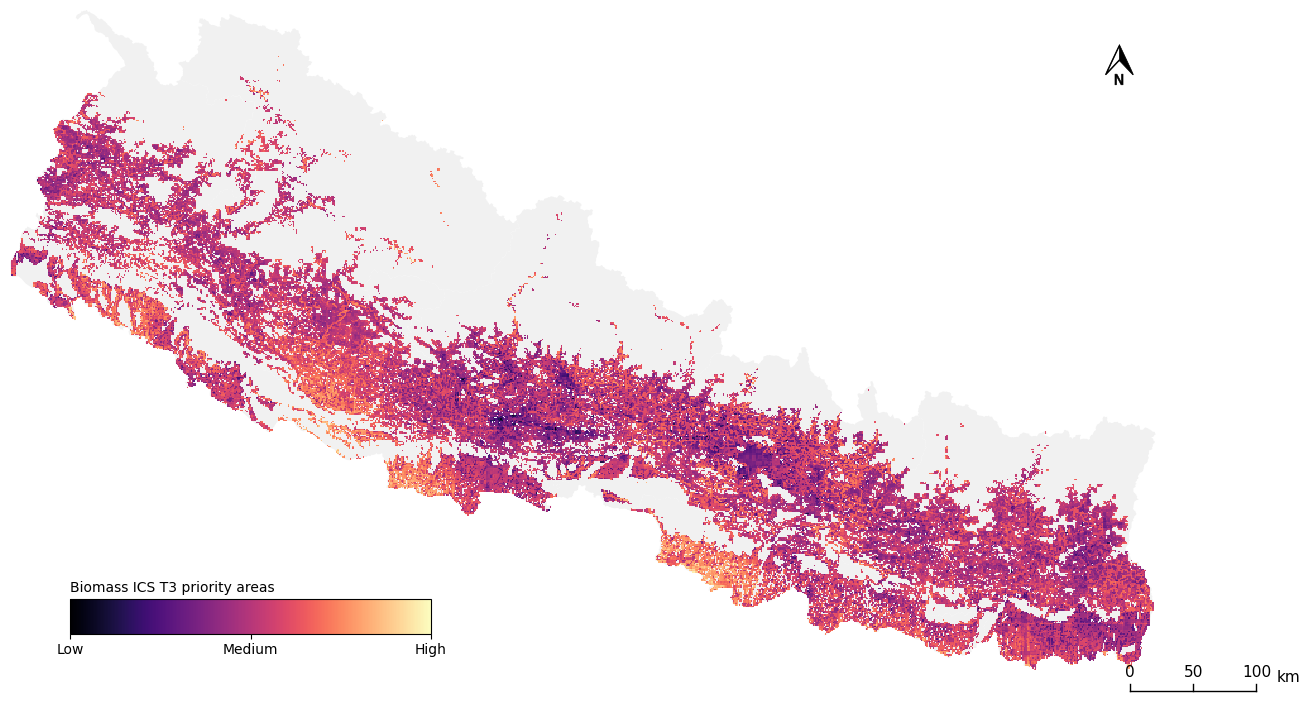

In [14]:
nepal.layers['Electricity']['Existing infra'].inverse = False
nepal.layers['OnStove']['LPG_cost_mean'].inverse = False
nepal.layers['Biomass']['Traveltime'].inverse = True
nepal.layers['Demographics']['Wealth'].inverse = True
nepal.layers['Demographics']['Population'].inverse = False
nepal.layers['OnStove']['maximum_net_benefit_per_household'].inverse = False
nepal.layers['OnStove']['available_biogas_mean'].inverse = True

nepal.layers['Electricity']['Existing infra'].distance_limit = None
nepal.layers['OnStove']['LPG_cost_mean'].distance_limit = None
nepal.layers['Biomass']['Traveltime'].distance_limit = None
nepal.layers['Demographics']['Wealth'].distance_limit = None
nepal.layers['Demographics']['Population'].distance_limit = None
nepal.layers['OnStove']['maximum_net_benefit_per_household'].distance_limit = None
nepal.layers['OnStove']['available_biogas_mean'].distance_limit = None

nepal.layers['Electricity']['Existing infra'].weight = 2.7
nepal.layers['OnStove']['LPG_cost_mean'].weight = 3.3
nepal.layers['Biomass']['Traveltime'].weight = 4.3
nepal.layers['Demographics']['Wealth'].weight = 4.6
nepal.layers['Demographics']['Population'].weight = 2
nepal.layers['OnStove']['maximum_net_benefit_per_household'].weight = 4.1
nepal.layers['OnStove']['available_biogas_mean'].weight = 3.3

biomass_ics_index = nepal.get_index(datasets={'Demographics': ['Population', 'Wealth'],
                                              'Electricity': ['Existing infra'],
                                              'Biomass': ['Traveltime'],
                                              'OnStove': ['LPG_cost_mean',
                                                          'maximum_net_benefit_per_household',
                                                          'available_biogas_mean']}, 
                                    buffer=True, name='Biomass ICS T3')
biomass_ics_index.name = 'Biomass_ICS_T3_priority_areas'
biomass_ics_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                       admin_layer=nepal.mask_layer, figsize=(16,9),
                       scale_bar=scale_bar_prop, 
                       north_arrow=north_arrow_prop,
                       colorbar_kwargs=dict(orientation='horizontal', x=0.05, y=0.1, width=0.3, height=0.05,
                                            title_prop=dict(loc='left', labelpad=-55, fontweight='normal'))
                       )
biomass_ics_index.save_image(name='../5. Results/Subsidies/Biomass_ICS_T3_priority_areas.pdf', 
                             cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                             admin_layer=nepal.mask_layer, figsize=(13,9),
                             scale_bar=scale_bar_prop, north_arrow=north_arrow_prop)

In [15]:
def histogram(model, index: RasterLayer, name: str):
    dff = model.gdf[['Households', 'max_benefit_tech']].copy()
    x = model.raster_to_dataframe(index, method='read')
    xf = pd.Series(x)

    dff[name] = xf
    dff = model._re_name(dff, labels, 'max_benefit_tech')
    dff = dff.loc[dff['max_benefit_tech']==name]

    # tech_list = dff.groupby('max_benefit_tech')[['Households']].sum()
    # tech_list = tech_list.reset_index().sort_values('Households')['max_benefit_tech'].tolist()
    dff['Households'] /= 1000
    # dff['max_benefit_tech'] = dff['max_benefit_tech'].astype("category").cat.reorder_categories(tech_list[::-1])

    max_val = dff[name].max()
    min_val = dff[name].min()
    binwidth = (max_val - min_val) * 0.05

    p = nepal_onstove._histogram(dff, cat='max_benefit_tech', x=name, 
                                 cmap = cmap, x_title = f'{name} priority index (-)', y_title = 'Households (k)',
                                 font_args=dict(color='black', size=11),
                                 kwargs=dict(binwidth=binwidth, alpha=0.8, size=0.2)) + theme(legend_position="none")
    
    # Add quantile lines
    q1, q3 = weighted_percentile(a=dff[name].values, q=(25, 75), weights=dff['Households'].values)
    line1 = geom_vline(xintercept=q1, color="#4D4D4D", size=0.8, linetype="dashed")
    line3 = geom_vline(xintercept=q3, color="#4D4D4D", size=0.8, linetype="dashed")

    hist = p + line1 + line3

    # get figure to annotate
    fig = hist.draw() # get the matplotlib figure object
    ax = fig.axes[0] # get the matplotlib axis (may be more than one if faceted)

    # annotate quantiles
    trans = ax.get_xaxis_transform()
    ax.annotate('Q1', xy=(q1, 1.05), xycoords=trans,
                horizontalalignment='center',
                color='#4D4D4D', weight="bold")
    ax.annotate('Q3', xy=(q3, 1.05), xycoords=trans,
                horizontalalignment='center',
                color='#4D4D4D', weight="bold")
    
    fig.set_size_inches(4, 2.5)
    fig.savefig(os.path.join(model.output_directory, f'{name.replace(" ", "_")}_index.pdf'), bbox_inches='tight', transparent=True)

C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 2802 rows containing non-finite values.


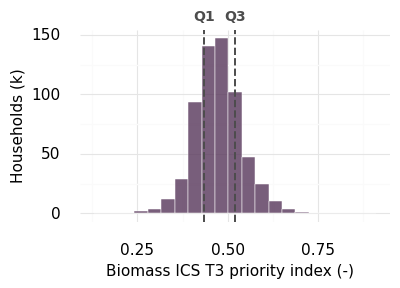

In [16]:
histogram(model=nepal_onstove, index=biomass_ics_index, name='Biomass ICS T3')

### 2.2.2. Biogas digesters and stoves
By 2025, install an additional 200,000 household biogas plants.

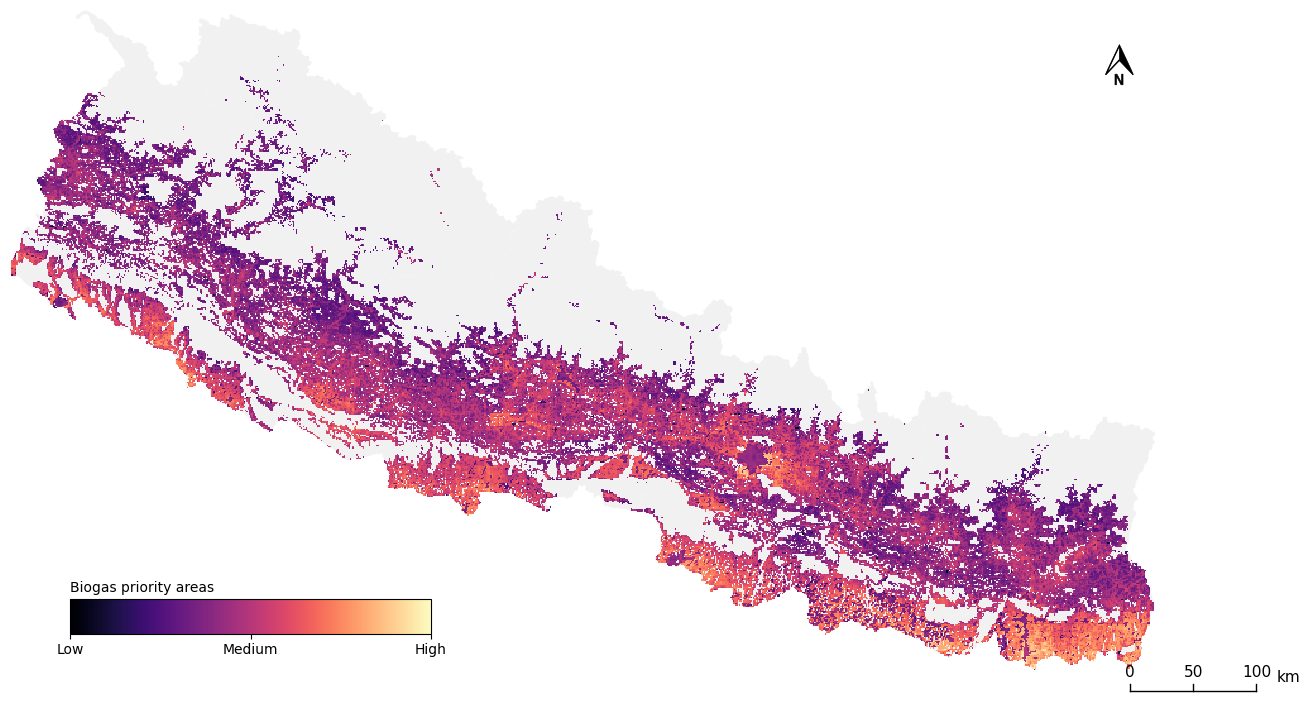

In [17]:
nepal.layers['Electricity']['Existing infra'].inverse = False
# nepal.layers['Electricity']['Existing Mini Grids'].inverse = False
nepal.layers['OnStove']['LPG_cost_mean'].inverse = False
nepal.layers['Biomass']['Traveltime'].inverse = False
nepal.layers['Demographics']['Wealth'].inverse = False
nepal.layers['Demographics']['Population'].inverse = True
nepal.layers['OnStove']['maximum_net_benefit_per_household'].inverse = False
nepal.layers['OnStove']['available_biogas_mean'].inverse = False

nepal.layers['Electricity']['Existing infra'].distance_limit = None
# nepal.layers['Electricity']['Existing Mini Grids'].distance_limit = None
nepal.layers['OnStove']['LPG_cost_mean'].distance_limit = None
nepal.layers['Biomass']['Traveltime'].distance_limit = None
nepal.layers['Demographics']['Wealth'].distance_limit = None
nepal.layers['Demographics']['Population'].distance_limit = None
nepal.layers['OnStove']['maximum_net_benefit_per_household'].distance_limit = None
nepal.layers['OnStove']['available_biogas_mean'].distance_limit = None

nepal.layers['Electricity']['Existing infra'].weight = 3
# nepal.layers['Electricity']['Existing Mini Grids'].weight = 1
nepal.layers['OnStove']['LPG_cost_mean'].weight = 3.5
nepal.layers['Biomass']['Traveltime'].weight = 2.7
nepal.layers['Demographics']['Wealth'].weight = 4
nepal.layers['Demographics']['Population'].weight = 3.3
nepal.layers['OnStove']['maximum_net_benefit_per_household'].weight = 4.2
nepal.layers['OnStove']['available_biogas_mean'].weight = 4.3

biogas_index = nepal.get_index(datasets={'Demographics': ['Population', 'Wealth'],
                                         'Electricity': ['Existing infra'],
                                         'Biomass': ['Traveltime'],
                                         'OnStove': ['LPG_cost_mean',
                                                     'maximum_net_benefit_per_household',
                                                     'available_biogas_mean']}, 
                               buffer=True, name='Biogas')
biogas_index.name = 'Biogas_priority_areas'
biogas_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                  admin_layer=nepal.mask_layer, figsize=(16,9),
                  scale_bar=scale_bar_prop, north_arrow=north_arrow_prop,
                  colorbar_kwargs=dict(orientation='horizontal', x=0.05, y=0.1, width=0.3, height=0.05,
                                            title_prop=dict(loc='left', labelpad=-55, fontweight='normal')))
biogas_index.save_image('../5. Results/Subsidies/Biogas_priority_areas.pdf', 
                        cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                         admin_layer=nepal.mask_layer, figsize=(13,9), 
                        scale_bar=scale_bar_prop, north_arrow=north_arrow_prop)

C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 4216 rows containing non-finite values.


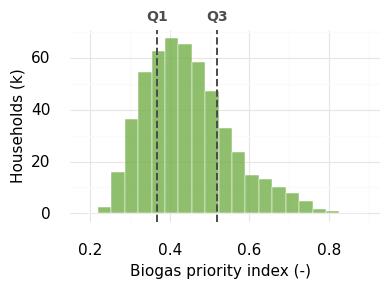

In [18]:
histogram(model=nepal_onstove, index=biogas_index, name='Biogas')

### 2.2.3. Induction electric cookstoves
By 2030, ensure 25% of households use electric stoves as their primary mode of cooking

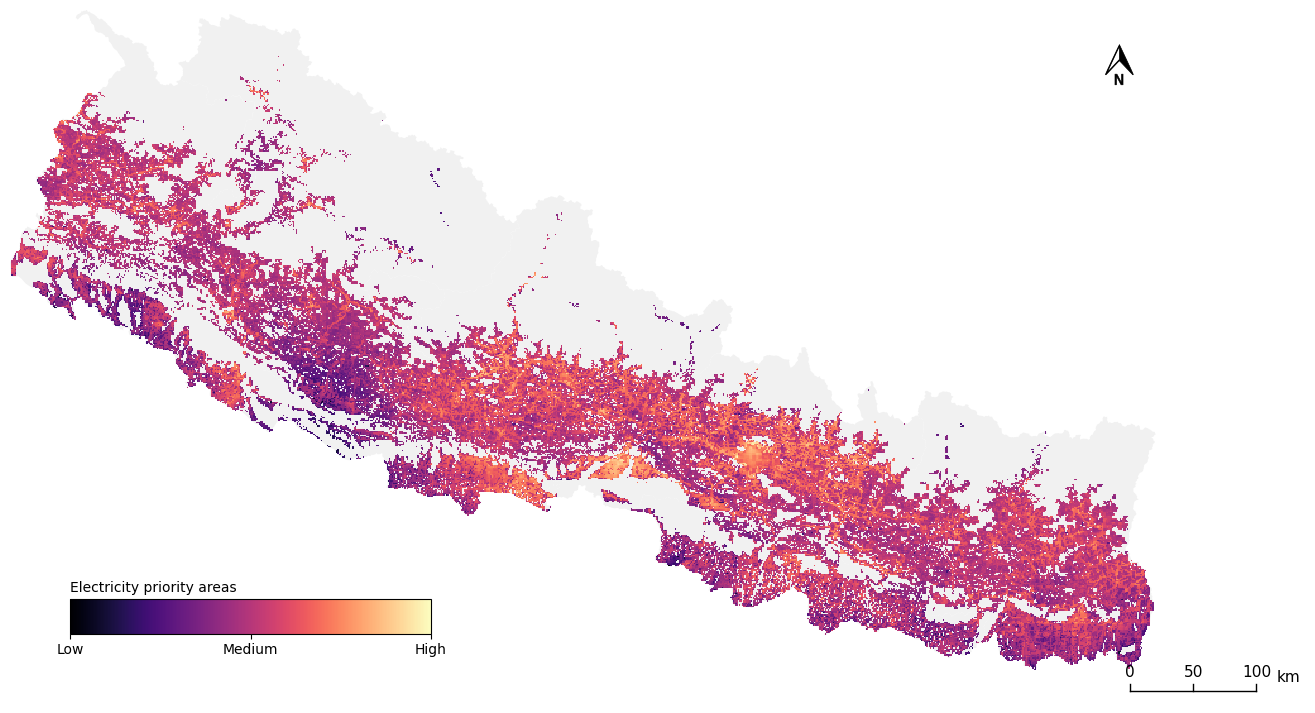

In [19]:
nepal.layers['Electricity']['Existing infra'].inverse = True
# nepal.layers['Electricity']['Existing Mini Grids'].inverse = True
nepal.layers['OnStove']['LPG_cost_mean'].inverse = False
nepal.layers['Biomass']['Traveltime'].inverse = False
nepal.layers['Demographics']['Wealth'].inverse = False
nepal.layers['Demographics']['Population'].inverse = False
nepal.layers['OnStove']['maximum_net_benefit_per_household'].inverse = False
nepal.layers['OnStove']['available_biogas_mean'].inverse = True

nepal.layers['Electricity']['Existing infra'].distance_limit = None
# nepal.layers['Electricity']['Existing Mini Grids'].distance_limit = None
nepal.layers['OnStove']['LPG_cost_mean'].distance_limit = None
nepal.layers['Biomass']['Traveltime'].distance_limit = None
nepal.layers['Demographics']['Wealth'].distance_limit = None
nepal.layers['Demographics']['Population'].distance_limit = None
nepal.layers['OnStove']['maximum_net_benefit_per_household'].distance_limit = None
nepal.layers['OnStove']['available_biogas_mean'].distance_limit = None

nepal.layers['Electricity']['Existing infra'].weight = 4.6
# nepal.layers['Electricity']['Existing Mini Grids'].weight = 2
nepal.layers['OnStove']['LPG_cost_mean'].weight = 3.8
nepal.layers['Biomass']['Traveltime'].weight = 2.3
nepal.layers['Demographics']['Wealth'].weight = 4.3
nepal.layers['Demographics']['Population'].weight = 3.5
nepal.layers['OnStove']['maximum_net_benefit_per_household'].weight = 4.4
nepal.layers['OnStove']['available_biogas_mean'].weight = 2.3

electricity_index = nepal.get_index(datasets={'Demographics': ['Population', 'Wealth'],
                                       'Electricity': ['Existing infra'],
                                       'Biomass': ['Traveltime'],
                                       'OnStove': ['LPG_cost_mean',
                                                   'maximum_net_benefit_per_household',
                                                   'available_biogas_mean']}, 
                             buffer=True, name='Electricity')
electricity_index.name = 'Electricity_priority_areas'
electricity_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                       admin_layer=nepal.mask_layer, figsize=(16,9),
                       scale_bar=scale_bar_prop, north_arrow=north_arrow_prop,
                       colorbar_kwargs=dict(orientation='horizontal', x=0.05, y=0.1, width=0.3, height=0.05,
                                            title_prop=dict(loc='left', labelpad=-55, fontweight='normal')))
electricity_index.save_image('../5. Results/Subsidies/Electricity_priority_areas.pdf', 
                             cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                             admin_layer=nepal.mask_layer, figsize=(13,9), dpi=300,
                             scale_bar=scale_bar_prop, north_arrow=north_arrow_prop)

C:\Users\camilorg\AppData\Local\miniconda3\envs\onstovejupyter\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 481 rows containing non-finite values.


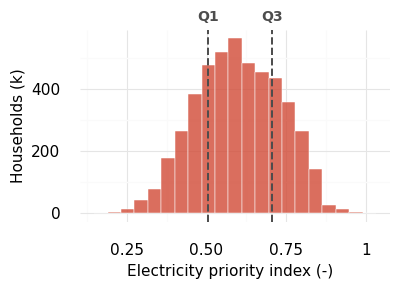

In [20]:
histogram(model=nepal_onstove, index=electricity_index, name='Electricity')

In [21]:
def prioritize_households(model, index, technology, goal):
    if 'Priorized_hh' not in model.gdf.columns:
        model.gdf['Priorized_hh'] = 'None'
    w = model.raster_to_dataframe(index, method='read')
    indices = np.where(~np.isnan(w))
    model.gdf['weights'] = 0
    model.gdf['weights'] = model.gdf.index.map(pd.Series(w, index=[x for x in range(len(w))]))

    households = 0
    step = 0.01
    i = 1
    # weights = sorted(w, reverse=True)
    
    if isinstance(technology, list):
        tech = technology[0]
    else:
        tech = technology
        technology = [technology]

    while households < goal:
        bool_vec = (model.gdf['weights'] >= i) & (model.gdf['max_benefit_tech'].isin(technology))
        _households = model.gdf.loc[bool_vec, "Households"].sum()

        if _households <= (goal * 1.01):
            households = _households
            model.gdf.loc[bool_vec, 'Priorized_hh'] = tech
        else:
            i += step
            step *= 0.1

        if i == 0:
            break
        i -= step
        if i < 0:
            i = 0
    print('Households:', households, 'Goal:', goal)

In [22]:
current_hh_electricity = nepal_onstove.specs['population_start_year'] * nepal_onstove.techs['Electricity'].current_share_urban / nepal_onstove.specs['urban_hh_size']
goal_elec = nepal_onstove.gdf['Households'].sum() * 0.25 # + current_hh_electricity

current_hh_biogas = nepal_onstove.specs['population_start_year'] * nepal_onstove.techs['Biogas'].current_share_rural / nepal_onstove.specs['rural_hh_size']
goal_biogas = 200000 # + current_hh_biogas

current_hh_ics_t3 = nepal_onstove.specs['population_start_year'] * nepal_onstove.techs['Biomass_ICS_T3'].current_share_rural / nepal_onstove.specs['rural_hh_size']
goal_biomass = 500000 # + current_hh_ics_t3

prioritize_households(nepal_onstove, electricity_index, ['Electricity', 'Mini_Grids'], goal_elec)
prioritize_households(nepal_onstove, biogas_index, 'Biogas', goal_biogas)
prioritize_households(nepal_onstove, biomass_ics_index, 'Biomass_ICS_T3', goal_biomass)

Households: 1670688.4160236968 Goal: 1663735.675408214
Households: 200796.89489838114 Goal: 200000
Households: 503431.05040448706 Goal: 500000


In [23]:
# Calculating subsidies
exchange_rate = 123.9838 # NPR/USD
## LPG
subsidy_lpg = 0
if scenario != 'Subsidies':
    subsidy_hh_lpg = nepal_onstove.techs['LPG'].energy / nepal_onstove.techs['LPG'].energy_content / 14.2 * 549.875 / exchange_rate
    subsidy_lpg = nepal_onstove.gdf.loc[nepal.gdf['Priorized_hh'] == 'LPG', 'Households'].sum() * subsidy_hh_lpg / 1000000000

## Biomass ICS
subsidy_ics = (nepal_onstove.gdf.loc[nepal_onstove.gdf['Priorized_hh']=='Biomass_ICS_T3', 'Households'] * 
               nepal_onstove.techs['Biomass_ICS_T3'].inv_cost).sum() / 1000000000
if scenario == 'Social':
    subsidy_ics *= 0.5

## Biogas
eco_zones = VectorLayer(path=r"..\2. Data\Other\Ecological zones\Ecological zones.geojson")
eco_zones.reproject(3857)
zones = nepal_onstove.gdf[['Households', 'geometry']].sjoin(eco_zones.data[['zone', 'geometry']], how='left')
nepal_onstove.gdf['eco_zone'] = zones['zone']
subsidy_biogas = nepal_onstove.gdf.loc[(nepal_onstove.gdf['Priorized_hh'] == 'Biogas') & 
                               (nepal_onstove.gdf['eco_zone'] == 'Terai'), 'Households'].sum() * 193.5736766
subsidy_biogas += nepal_onstove.gdf.loc[(nepal_onstove.gdf['Priorized_hh'] == 'Biogas') & 
                                (nepal_onstove.gdf['eco_zone'] == 'Hills'), 'Households'].sum() * 262.1310203
subsidy_biogas += nepal_onstove.gdf.loc[(nepal_onstove.gdf['Priorized_hh'] == 'Biogas') & 
                                (nepal_onstove.gdf['eco_zone'] == 'Mountain'), 'Households'].sum() * 314.5572244
subsidy_biogas /= 1000000000

## Electricity
subsidy_electricity = 0
if scenario in ['Subsidies']:
    increment = 549.875 / (exchange_rate * 14.2) # USD per kg
    
    increment_per_MJ = increment / nepal_onstove.techs['LPG'].energy_content # in USD/MJ
    subsidy_per_kwh = increment_per_MJ * nepal_onstove.techs['Electricity'].energy_content # in USD/kWh
    
    kwh_grid = nepal_onstove.techs['Electricity'].energy / nepal_onstove.techs['Electricity'].energy_content
    kwh_minigrid = nepal_onstove.techs['Mini_Grids'].energy / nepal_onstove.techs['Mini_Grids'].energy_content
    
    subsidy_electricity = nepal_onstove.gdf.loc[nepal_onstove.gdf['Priorized_hh'] == 'Electricity', 'Households'].sum() * kwh_minigrid * subsidy_per_kwh
    subsidy_electricity += nepal_onstove.gdf.loc[nepal_onstove.gdf['Priorized_hh'] == 'Mini_Grids', 'Households'].sum() * kwh_minigrid * subsidy_per_kwh
    subsidy_electricity /= 1000000000
    
all_subsidies = subsidy_lpg + subsidy_ics + subsidy_biogas + subsidy_electricity

# Calculating total system cost
summary = nepal_onstove.summary(total=True, pretty=False, variable='Priorized_hh', remove_none=True)
total_costs = (summary.loc['total', 'investment_costs'] + summary.loc['total', 'fuel_costs'] + 
               summary.loc['total', 'om_costs'] - summary.loc['total', 'salvage_value']) / 1000

if scenario != 'Social':
    total_costs += all_subsidies

In [24]:
subsidies_df = pd.DataFrame({'LPG subsidies (BUS$)': [subsidy_lpg],
                             'Biomass ICS T3 subsidies (BUS$)': [subsidy_ics],
                             'Biogas subsidies (BUS$)': [subsidy_biogas],
                             'Electricity subsidies (BUS$)': [subsidy_electricity]},
                            index=['Subsidies prioritized'])
subsidies_df.to_csv(os.path.join(nepal_onstove.output_directory, 'Subsidies_prioritized.csv'))
subsidies_df

,LPG subsidies (BUS$),Biomass ICS T3 subsidies (BUS$),Biogas subsidies (BUS$),Electricity subsidies (BUS$)
Subsidies prioritized,0,0.011831,0.044895,0.048936


<AxesSubplot:>

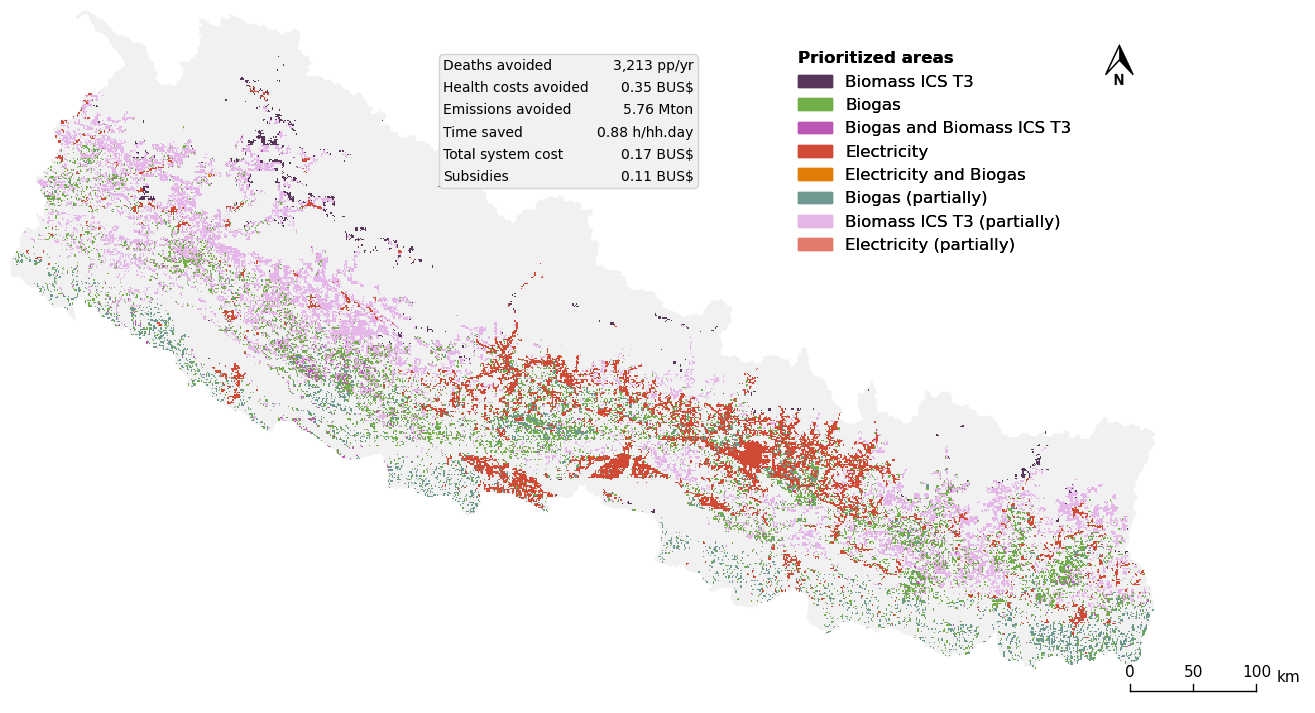

In [25]:
cmap = {"Biomass ICS T3": '#57365A', "LPG": '#40bdbc', "Traditional Biomass": '#673139',
        "Biogas": '#73af48', "Biogas and Biomass ICS T2": "#F6029E", "Biomass ICS T2": '#B6195E',
        "Biogas and LPG": "#156e5e",  "Biogas and Traditional Biomass": "#266AA6",
        "Biogas and Biomass ICS T3": "#bd57b6", "Biogas and Electricity": "#484673",
        "Electricity": '#d14a36', "Electricity and Biomass ICS T2": "#4D7126",
        "Electricity and LPG": "#dec610", "Electricity and Traditional Biomass": "#FFC107",
        "Electricity and Biomass ICS T3": "#1E88E5", "Electricity and Biogas": "#e17c05",
        "Mini Grids": "#ff7678", "Electricity and Mini Grids": "#ffd9df",
        "Biogas and Mini Grids": "#ffd9df", 'None': '#f1f1f1', 
        'Biogas (partially)': '#6d9991', 'Biomass ICS T3 (partially)': '#e4b7e8',
        'Electricity (partially)': '#e37a6b'}

labels = {"Biogas and Electricity": "Electricity and Biogas",
          # 'None': 'No action',
          # 'No action and No action': 'No action',
          "Electricity and None": 'Electricity (partially)',
          "None and Electricity": 'Electricity (partially)',
          "Biogas and None": 'Biogas (partially)',
          "None and Biogas": 'Biogas (partially)',
          "None and Biomass ICS T3": 'Biomass ICS T3 (partially)'}

scale_bar_prop = dict(size=100000, style='double', textprops=dict(size=11),
                      linekw=dict(lw=1, color='black'), extent=0.01, loc='lower center')
north_arrow_prop = dict(size=30, location=(0.92, 0.92), linewidth=0.5)

nepal_onstove.plot('Priorized_hh', cmap=cmap,
                   labels=labels,
                   legend_position=(0.65, 0.95), 
                   figsize=(16,9),  
                   legend_title='Prioritized areas',
                   stats=True, 
                   scale_bar=scale_bar_prop, north_arrow=north_arrow_prop,
                   stats_kwargs=dict(extra_stats={'Total system cost': f'{total_costs:.2f} BUS$',
                                                  'Subsidies': f'{all_subsidies:.2f} BUS$'},
                                     stats_position=(0.36, 0.93)))

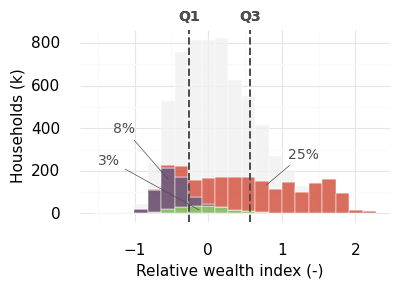

<Figure size 640x480 with 0 Axes>

In [26]:
plt.clf()

# Draw histogram
max_val = nepal_onstove.gdf['relative_wealth'].max()
min_val = nepal_onstove.gdf['relative_wealth'].min()
binwidth = (max_val - min_val) * 0.05

fig = nepal_onstove.plot_distribution(type='histogram', fill='Priorized_hh', variable='relative_wealth', 
                                       groupby='None', cmap=cmap, labels=labels, 
                                       hh_divider=1000, y_title='Households (k)', font_args=dict(color='black', size=11),
                                       height=2.5, width=4, kwargs=dict(binwidth=binwidth, alpha=0.8, size=0.2),
                                       theme_name='minimal', quantiles=True)

# Add quantile lines
q1, q3 = weighted_percentile(a=nepal_onstove.gdf['relative_wealth'].values, q=(25, 75), weights=nepal_onstove.gdf['Households'].values)

# get figure to annotate
ax = fig.axes[0] # get the matplotlib axis (may be more than one if faceted)

# annotate quantiles
trans = ax.get_xaxis_transform()
ax.annotate('Q1', xy=(q1, 1.05), xycoords=trans,
            horizontalalignment='center',
            color='#4D4D4D', weight="bold")
ax.annotate('Q3', xy=(q3, 1.05), xycoords=trans,
            horizontalalignment='center',
            color='#4D4D4D', weight="bold")

# annotate percentages
dff = nepal_onstove.gdf.groupby('Priorized_hh')['Households'].sum()
dff.sort_values(inplace=True)
total = dff.sum()
## Dictionaries to set the possition of the arrows and text in the histogram
y_arrow_dict = {'Electricity': 125, 'LPG': 180, 'Biogas': 10, 'Biomass_ICS_T3': 150, 'Mini_Grids': 0}
y_text_dict= {'Electricity': 280, 'LPG': 300, 'Biogas': 250, 'Biomass_ICS_T3': 400, 'Mini_Grids': 100}
x_text_dict = {'Electricity': 1.5, 'LPG': 2, 'Biogas': -1.2, 'Biomass_ICS_T3': -1, 'Mini_Grids': -1.3}

## Draw arrows and text
for tech in dff.index:
    if tech != 'None':
        group = nepal_onstove.gdf.loc[nepal_onstove.gdf['Priorized_hh']==tech]
        hh = group['Households'].sum()
        share = hh/total
        if share > 0.01:
            x = weighted_percentile(a=group['relative_wealth'].values, q=(50), weights=group['Households'].values)
            y_arrow = y_arrow_dict[tech]
            y_text = y_text_dict[tech]
            x_text = x_text_dict[tech]

            ax.annotate(xy=(x, y_arrow),
                        xytext=(x_text, y_text), text=f'{share:.0%}',
                        horizontalalignment='right', verticalalignment='center',
                        arrowprops={'arrowstyle': '-', 'color': '#4D4D4D', 'lw': 0.5},
                        color='#4D4D4D')
        
fig.set_size_inches(4, 2.5)
fig.savefig(os.path.join(nepal_onstove.output_directory, 'tech_histogram_prioritized.pdf'), bbox_inches='tight', transparent=True)
fig

In [27]:
q1, q3 = weighted_percentile(a=nepal_onstove.gdf['relative_wealth'].values, q=(25, 75), weights=nepal_onstove.gdf['Households'].values)
nepal_onstove.gdf.loc[nepal_onstove.gdf['relative_wealth']>q3, 'wealth_q'] = '>Q3'
nepal_onstove.gdf.loc[nepal_onstove.gdf['relative_wealth']<=q3, 'wealth_q'] = 'Q1-Q3'
nepal_onstove.gdf.loc[nepal_onstove.gdf['relative_wealth']<=q1, 'wealth_q'] = 'Q1'
# nepal_onstove.gdf.loc[nepal_onstove.gdf['relative_wealth']<=q40, 'wealth_q'] = 'Q40'
# nepal_onstove.gdf.loc[nepal_onstove.gdf['relative_wealth']<=q20, 'wealth_q'] = 'Q20'
total = nepal_onstove.gdf.groupby(['Priorized_hh']).agg({'Calibrated_pop': 'sum'})
dff = nepal_onstove.gdf.groupby(['Priorized_hh', 'wealth_q']).agg({'Calibrated_pop': 'sum'}).reset_index()
dff['percentage'] = dff['Calibrated_pop'] / dff.reset_index()['Priorized_hh'].map(total['Calibrated_pop'])
dff

,Priorized_hh,wealth_q,Calibrated_pop,percentage
0,Biogas,>Q3,4.765074e+04,0.055188
1,Biogas,Q1,2.923780e+05,0.338625
2,Biogas,Q1-Q3,5.233979e+05,0.606187
3,Biomass_ICS_T3,Q1,1.992571e+06,0.920461
4,Biomass_ICS_T3,Q1-Q3,1.721829e+05,0.079539
5,Electricity,>Q3,4.523925e+06,0.609984
6,Electricity,Q1,3.617668e+05,0.048779
7,Electricity,Q1-Q3,2.530778e+06,0.341238
8,None,>Q3,2.930265e+06,0.156763
9,None,Q1,4.523356e+06,0.241990


In [28]:
nepal_onstove.to_image('Priorized_hh', name='Priorized_hh.pdf', cmap=cmap, 
                       figsize=(13, 9), dpi=300, 
                       labels=labels, legend=False, legend_title='Maximum benefit\ncooking technology', 
                       rasterized=True, stats=True, 
                       scale_bar=scale_bar_prop, north_arrow=north_arrow_prop,
                       stats_kwargs=dict(extra_stats={'Total system cost': f'{total_costs:.2f} BUS$',
                                                      'Subsidies': f'{all_subsidies:.2f} BUS$'},
                                         stats_position=(0, 0.28), stats_fontsize=14))

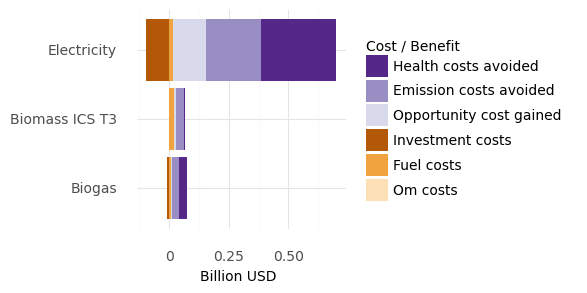

In [29]:
nepal_onstove.plot_costs_benefits(labels=labels, height=70/24.5, width=66/24.5,
                                  save_as='cost_benefits_prioritized', 
                                  variable='Priorized_hh')

In [30]:
print(nepal_onstove.clean_cooking_access_u, nepal_onstove.clean_cooking_access_r)

0.526 0.306


In [31]:
nepal_onstove.gdf['urban'] = nepal_onstove.gdf['IsUrban'] > 20
dff = nepal_onstove.gdf.groupby(['urban', 'Priorized_hh'])[['Calibrated_pop']].sum().reset_index()
clean = dff['urban'] & (dff['Priorized_hh'].isin(['Electricity', 'Biogas']))
none = dff['urban'] & (dff['Priorized_hh']=='None')
total_u = dff.loc[clean, 'Calibrated_pop'].sum() + dff.loc[none, 'Calibrated_pop'].sum()
(dff.loc[clean, 'Calibrated_pop'].sum() + dff.loc[none, 'Calibrated_pop'].sum() * nepal_onstove.clean_cooking_access_u) / total_u

0.7376380273895511

In [35]:
clean = (~dff['urban']) & (dff['Priorized_hh'].isin(['Electricity', 'Biogas']))
none = (~dff['urban']) & (dff['Priorized_hh']=='None')
total_r = dff.loc[clean, 'Calibrated_pop'].sum() + dff.loc[none, 'Calibrated_pop'].sum()
(dff.loc[clean, 'Calibrated_pop'].sum() + dff.loc[none, 'Calibrated_pop'].sum() * nepal_onstove.clean_cooking_access_r) / total_r

0.4906332747448429

In [38]:
0.7376380273895511 - 0.526

0.21163802738955106

In [39]:
0.4906332747448429 - 0.306

0.18463327474484292